### Import Kepler data for GJ 1243

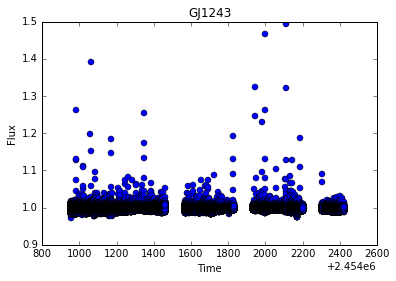

In [35]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/astro/users/bmmorris/git/hat-11/data/')
from datacleaner import LightCurve
from glob import glob
import numpy as np

long_cadence_paths = glob('/media/PASSPORT/hcts/gj1243/*llc.fits')
gj1243 = LightCurve.from_raw_fits(long_cadence_paths, name='GJ1243')
gj1243.normalize_each_quarter()
gj1243.plot()

Use LS periodogram to measure period on full light curve (this takes about 2 minutes)

Best period: 0.592611394461


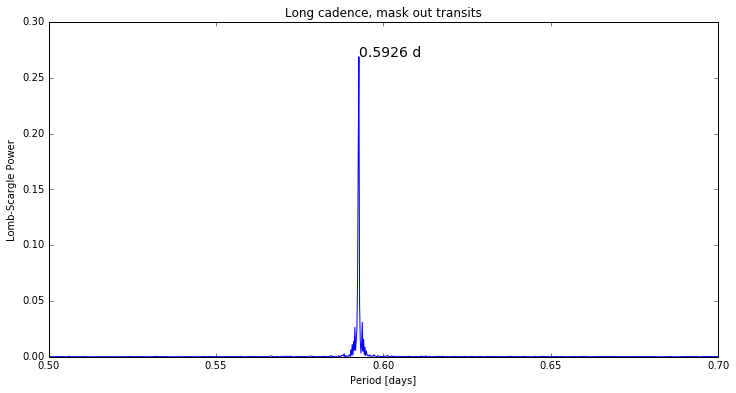

In [41]:
from gatspy import periodic
import warnings

model = periodic.LombScargle(fit_period=True, Nterms=4, optimizer_kwds={'quiet': True})
model.optimizer.period_range = (0.55, 0.65)
model.fit(gj1243.times.jd, gj1243.fluxes, gj1243.errors);

periods = np.linspace(model.optimizer.period_range[0],
                      model.optimizer.period_range[1], 
                      1000)
print("Best period: {0}".format(model.best_period))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)

fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(periods, scores)
ax.set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence, mask out transits')
max_ind = np.argmax(scores)
ax.text(periods[max_ind], scores[max_ind], 
        "{0:.4f} d".format(model.best_period),
        fontsize=14)
plt.show()

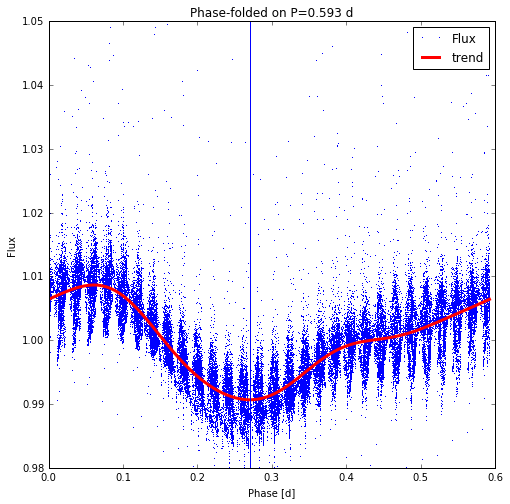

In [116]:
phase = gj1243.times.jd % model.best_period
tfit = np.linspace(0, model.best_period, 100)
yfit = model.predict(tfit, period=model.best_period)

# Find time at folded phase minimum: 
def folded_flux_model(params):
    t = params[0]
    return model.predict(t, period=model.best_period)

from scipy import optimize
result = optimize.minimize(folded_flux_model, [tfit[np.argmin(yfit)]])
phase_min = result.x[0]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phase, gj1243.fluxes, ',', label='Flux')
ax.plot(tfit, yfit, 'r', lw=3, label='trend')
ax.set(xlabel='Phase [d]', ylabel='Flux', title='Phase-folded on P={0:.3f} d'.format(model.best_period),
       ylim=(0.98, 1.05))
ax.axvline(phase_min)
ax.legend()
plt.show()

T_0 = 2455630.77324


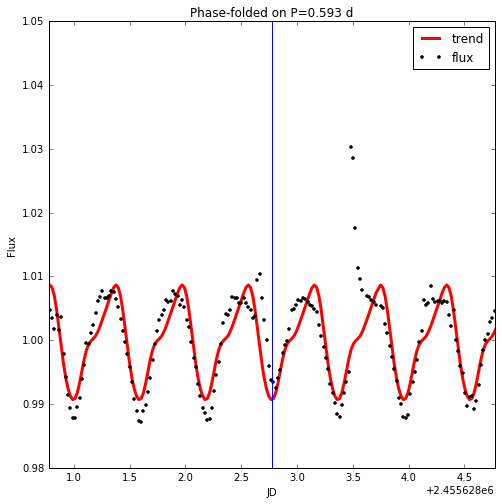

In [132]:
#phase = gj1243.times.jd % model.best_period
all_t = gj1243.times.jd #np.linspace(0, model.best_period, 100)
all_y = model.predict(gj1243.times.jd, period=model.best_period)

# Find time at folded phase minimum: 
def folded_flux_model(params):
    t = params[0]
    return model.predict(t, period=model.best_period)

from scipy import optimize
result = optimize.minimize(folded_flux_model, [all_t.mean()])
t_min = result.x[0]

print('T_0 = {0}'.format(t_min))

fig, ax = plt.subplots(figsize=(8,8))
#ax.plot(phase, gj1243.fluxes, ',', label='Flux')
n_pts = len(all_t)#200
ax.plot(all_t[:n_pts], all_y[:n_pts], 'r', lw=3, label='trend')
ax.plot(gj1243.times.jd[:n_pts], gj1243.fluxes[:n_pts], 'k.', label='flux')
ax.set(xlabel='JD', ylabel='Flux', title='Phase-folded on P={0:.3f} d'.format(model.best_period),
      ylim=(0.98, 1.05), xlim=(t_min - 2, t_min + 2))
ax.axvline(t_min)
ax.legend()
plt.show()

In [127]:
t0_brett = t_min.copy()

(t0_jrad - t0_brett) / model.best_period

-1346.0044365899391

In [133]:
t0_jrad

2454833.11567807

In [129]:
0.004*model.best_period * 24 * 60

3.4134416320944942

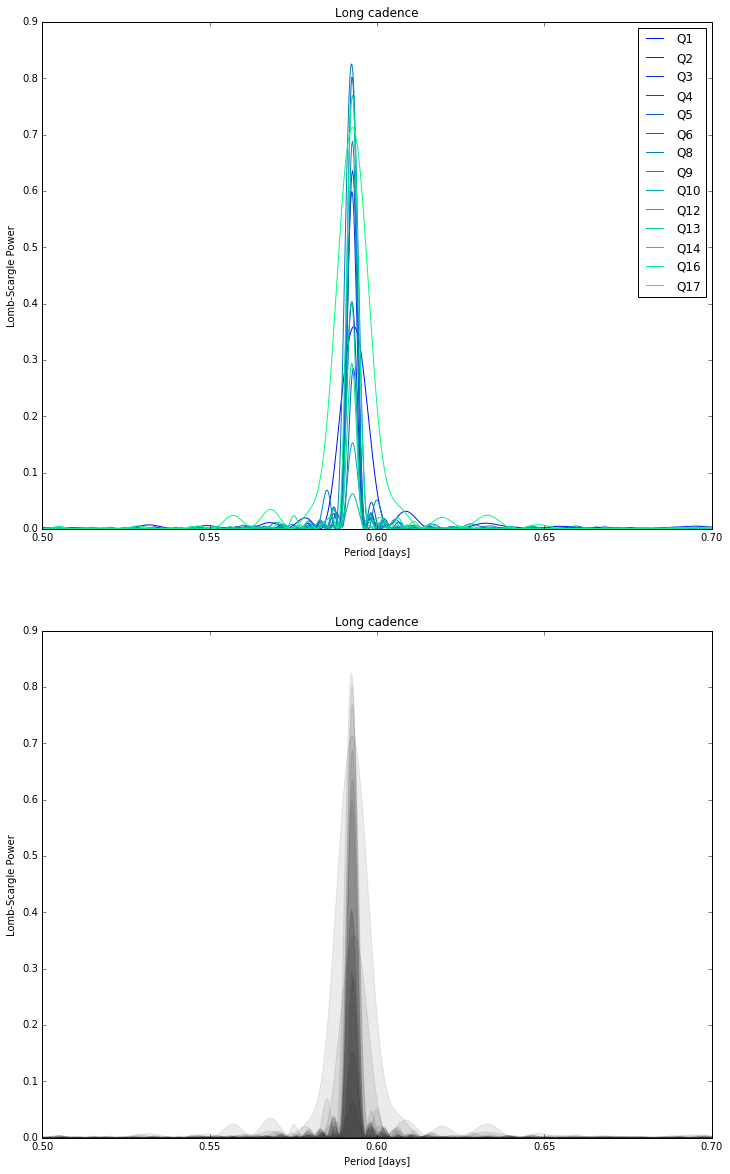

In [38]:
available_quarters = gj1243.get_available_quarters()

# Ignore quarter zero!
available_quarters.pop(0)

best_periods = np.zeros(len(available_quarters))

fig, ax = plt.subplots(2, 1, figsize=(12, 20))

quarter_period_range = (0.55, 0.65)
quarter_periods = np.linspace(quarter_period_range[0],
                              quarter_period_range[1], 
                              1000)

my_cmap = lambda j: plt.cm.winter(float(j+1)/len(available_quarters))

for i, quarter in enumerate(available_quarters):
    lc = gj1243.get_quarter(quarter)
    quarter_model = periodic.LombScargleFast(fit_period=True)
    quarter_model.optimizer.period_range = quarter_period_range
    quarter_model.optimizer.quiet = True
    quarter_model.fit(lc.times.jd, lc.fluxes, lc.errors);

    best_periods[i] = quarter_model.best_period
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores = quarter_model.score(quarter_periods)
        
    ax[0].plot(quarter_periods, scores, label='Q{0}'.format(quarter), 
            color=my_cmap(i))

    ax[1].fill_between(quarter_periods, 0, scores, color='k', alpha=0.08)
    
ax[0].set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence')
ax[0].legend()

ax[1].set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence')
plt.show()

In [96]:
lc = gj1243.get_quarter(2)

import george
from george import kernels

#kernel = kernels.CosineKernel(period=model.best_period)
kernel = kernels.ExpSine2Kernel(period=model.best_period, gamma=5)

gp = george.GP(kernel, mean=np.mean(lc.fluxes), solver=george.BasicSolver)
gp.compute(lc.times.jd, lc.errors)

import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(lc.fluxes, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(lc.fluxes, quiet=True)

# You need to compute the GP once before starting the optimization.
#gp.compute(t)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(lc.fluxes))

# Run the optimization routine.
p0 = gp.kernel.get_vector() #.vector
results = op.minimize(nll, p0, jac=grad_nll)

# Update the kernel and print the final log-likelihood.
gp.kernel[:] = results.x

-48825342.2948


In [97]:
print(results)

   status: 2
  success: False
     njev: 3
     nfev: 15
 hess_inv: array([[1, 0],
       [0, 1]])
      fun: 48825342.294800363
        x: array([ 5.        , -0.52321642])
  message: 'Desired error not necessarily achieved due to precision loss.'
      jac: array([ -2.88235336e+03,   4.06356033e+08])
      nit: 0


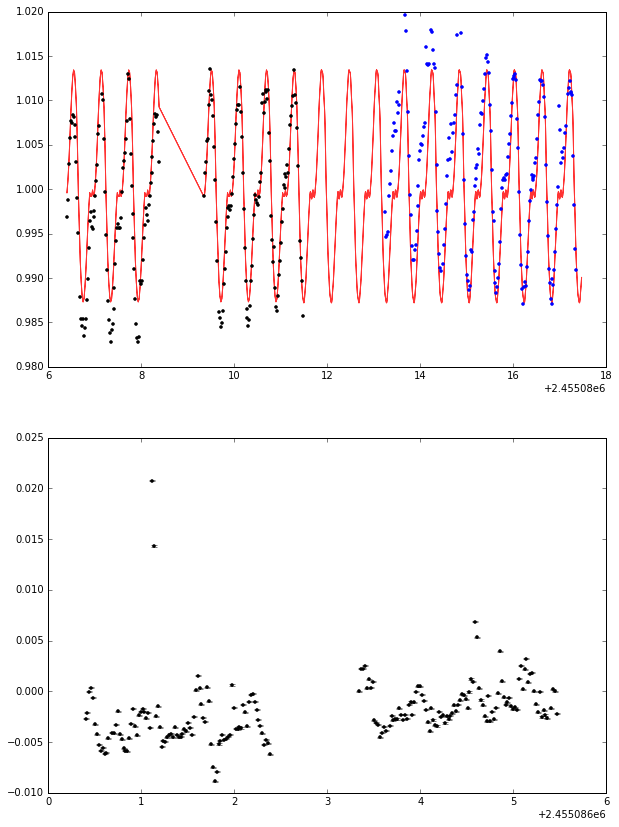

In [99]:
#x = np.linspace(max(lc.times.jd), lc.times.jd.max()+10, 2000)
n_pts = 200

x = np.concatenate([lc.times.jd[-n_pts:], 
                    np.linspace(max(lc.times.jd), lc.times.jd.max()+6, 2000)])
mu, cov = gp.predict(lc.fluxes, x)
std = np.sqrt(np.diag(cov))

fig, ax = plt.subplots(2, 1, figsize=(10, 14))
ax[0].plot(lc.times.jd[-n_pts:], lc.fluxes[-n_pts:], 'k.')
ax[0].fill_between(x, mu+std, mu-std, color='r', alpha=0.8)
ax[0].set(ylim=[0.98, 1.02])
#plt.xlim([90, 100])

lc2 = gj1243.get_quarter(3)
ax[0].plot(lc2.times.jd[:n_pts], lc2.fluxes[:n_pts], 'b.')

ax[1].errorbar(lc.times.jd[-n_pts:], lc.fluxes[-n_pts:] - mu[:n_pts], 
               lc.errors[-n_pts:], fmt='.', color='k')
plt.show()


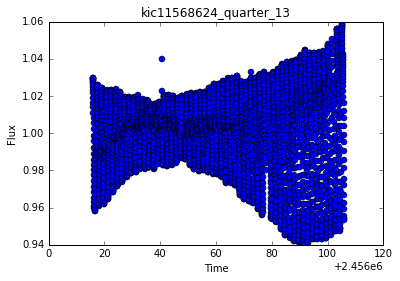

In [160]:
long_cadence_paths = glob('/media/PASSPORT/hcts/kic11568624/*llc.fits')
kic115 = LightCurve.from_raw_fits(long_cadence_paths, name='kic11568624')
kic115.normalize_each_quarter()
kic115.get_quarter(13).plot(show=False)
plt.savefig('kic11568624.png')

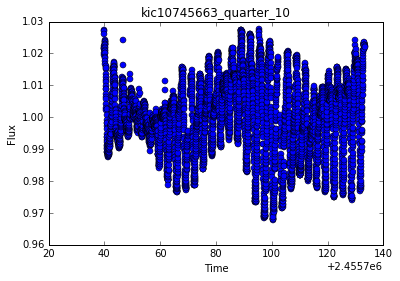

In [161]:
long_cadence_paths = glob('/media/PASSPORT/hcts/kic10745663/*llc.fits')
kic107 = LightCurve.from_raw_fits(long_cadence_paths, name='kic10745663')
kic107.normalize_each_quarter()
kic107.get_quarter(10).plot(show=False)
plt.savefig('kic10745663.png')